<a href="https://colab.research.google.com/github/prasvijaya/datascienceportfolio/blob/master/Sentimental_analysis_using_GBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install default-jre
!java-version 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/bin/bash: java-version: command not found


In [2]:
!pip install h2o

     |████████████████████████████████| 129.3MB 93kB/s 
  Created wheel for h2o: filename=h2o-3.30.1.1-py2.py3-none-any.whl size=129358602 sha256=7c675c190d07303bf5f0dcc48e9ba60702dd264ef26dbab447f373b5c6c91a26
  Stored in directory: /root/.cache/pip/wheels/33/ac/52/165c35d747abdb629c3c9fb7e087f360c662d8cb58824caed8
Successfully built h2o


In [3]:
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h2o
import nltk
import spacy
import re
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from h2o.automl import H2OAutoML

In [4]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3078o4ke
  JVM stdout: /tmp/tmp3078o4ke/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp3078o4ke/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,"21 days, 20 hours and 21 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_ehe5aa
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [5]:
dataset, info = tfds.load('amazon_us_reviews/Personal_Care_Appliances_v1_00', with_info=True, batch_size=-1)
train_dataset= dataset['train']

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/amazon_us_reviews/Personal_Care_Appliances_v1_00/0.1.0.incompleteXQR34L/amazon_us_reviews-train.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset amazon_us_reviews downloaded and prepared to /root/tensorflow_datasets/amazon_us_reviews/Personal_Care_Appliances_v1_00/0.1.0. Subsequent calls will reuse this data.


In [6]:
info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

In [7]:
dataset= tfds.as_numpy(train_dataset)
dataset

{'data': {'customer_id': array([b'13986323', b'50574716', b'50593972', ..., b'40719682',
         b'35596948', b'29430209'], dtype=object),
  'helpful_votes': array([0, 3, 0, ..., 0, 0, 0], dtype=int32),
  'marketplace': array([b'US', b'US', b'US', ..., b'US', b'US', b'US'], dtype=object),
  'product_category': array([b'Personal_Care_Appliances', b'Personal_Care_Appliances',
         b'Personal_Care_Appliances', ..., b'Personal_Care_Appliances',
         b'Personal_Care_Appliances', b'Personal_Care_Appliances'],
        dtype=object),
  'product_id': array([b'B00847JQZ6', b'B00N5HD340', b'B0077L1X24', ..., b'B000UZ8X2W',
         b'B000NURPPK', b'B001EY5GNW'], dtype=object),
  'product_parent': array([b'997683625', b'955577225', b'120764066', ..., b'96066145',
         b'58591097', b'986877728'], dtype=object),
  'product_title': array([b'SE - Reading Glass - Spring Loaded Hinges, 4.0x - RTS62400',
         b'Straight Razor',
         b'Philips Sonicare Flexcare & Healthy White Plastic

We have review_body, review_headline consists of unstructured Text data. We will use these two columns for our building. Based on our baseline performance we will add new features based on weightage. star_rating will consists of rating ranges from 1-5 where 5 is highest rating. We need to perform sentiment analysis based on star_rating. We can either consider this target class as it to build multiclassification or transform to have 2 class labels for Binary Classification. For now, we will build it binary clasification

In [8]:
review_headline= dataset['data']['review_headline']
review_body= dataset['data']['review_body']
rating= dataset['data']['star_rating']

based on above 3 variables, we will create H20 dataframe like we create pandas dataframe.

In [9]:
h2o_df=h2o.H2OFrame(np.hstack((review_headline[:,None],review_body[:,None],rating[:,None])),column_names=['headline','reviews','rating'],column_types=['string','string','numeric'])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [10]:
h2o_df.head()

headline,reviews,rating
b'These glasses are an excellent value. The fit is good and they are ...',"b""These glasses are an excellent value. The fit is good and they are very comfortable. Because of my legal blindness, there aren't a lot of options to try to see better, but I believe these help with my other visual aids, and because they are reasonably priced I can have more than one pair available.""",4
b'A fantastic way to cheaply try straight razor shaving.',"b""Always wanted to try straight razor shaving (as a DE safety razor user), and this was a cheap way for me to determine I was not into it.<br /><br />Because the blades are disposable and always sharp, I could put a new one in and reasonably rely upon that fact that cuts were probably due to my technique and not the blade.<br /><br />It's very hard to do straight razor shaving on yourself because the ANGLE is difficult to control without switching hands. Being very right-handed, I really couldn't do that. I bet I could shave someone else's face with it though.<br /><br />An immediate upside? Using a DE safety razor (slant edged even) seems SUPER safe now! I'm increased my speed with the DE due to that confidence, and I'd been using it for years now.""",5
b'Great for travel',"b'I usually either throw my toothbrush in a plastic bag with spare head so this product is very convenient for keeping all the parts apart, dry and undamaged, and i now keep it in my travel bag all the time ready to go.'",4
b'Five Stars',b'Top quality.',5
b'*Product sent not as shown',"b'Today I received 1 Fl. Oz, Natures Balance AlkaMAX alkaline booster liquid unflavored (formally TriMedica) a glass brown bottle with eye dropper.<br />Supplement Facts; Serving Size: 10 Drops (Approx. 0.5 mL). Servings per Container: Approx. 60<br />Amount Per Serving % Daily Value<br />Magnesium (as Magnesium Chloride) 40 mg 10%<br />Chloride (as Magnesium Chloride) 64 mg 2%<br />Other Ingredients: Deionized water and trace mineral complex.<br />Directions: Add 10 drops to 8 oz. of water or other beverage daily as needed or as directed by your health care practitioner. Store in a cool, dry place.<br /><br />I have not used product as of yet with changed ingredients of original/as shown in AlkaMax alkaline support white squeeze bottle.<br />but had to rate to post...heck this new may be better for all I know.'",3
b'Seems to work well!',"b'I recently picked this unit up at Bed and Bath where it was $99.00. With a 20% coupon the price was $80 (so comparison shop!) It\'s easy to use and seems to work well. I agree with other reviewers about the noise level (loud like a tea kettle boiling), but I use this unit in the living room area so sleeping is not an issue. Having the 2 separate water reservoirs to fill is much easier, weight-wise, as I previously had another humidifier which had one large water reservoir and it was very heavy when full. The unit comes apart quite easily for cleaning and since frequent cleaning is recommended (I usually do it 1x per week, not daily) this is a definite plus. Additionally, one only needs to use vinegar to clean the inside reservoir, which is a lot cheaper than having to buy some kind of \\\\""special\\\\"" cleaning solution. My one complaint is that it doesn\'t, but should, have an automatic shut off when both tanks are empty.I have to remember to turn the unit off when I leave the house. My previous humidifiers all had this auto turn off; seems like every humidifier should.'",4
b'deep heat?????',"b'Not sure what previous reviewer was talking about. The product uses ULTRASOUND waves for pain relief NOT heat. After repeated use, the pain in my knee and shoulder was feeling great. I think you should re-read the description and reconsider your opinion. Great product sold by a great company.'",5
b'Thermometer for a toddler',"b""The shippers were great....willing to consider speedier shipping options, but in the end the standard shipping arrived quickly enough. The thermometer is fun and

In [11]:
h2o_df.shape

(85981, 3)

In [12]:
h2o_df.describe()

Rows:85981
Cols:3




,headline,reviews,rating
type,string,string,int
mins,NaN,NaN,1.0
mean,NaN,NaN,3.9774019841592847
maxs,NaN,NaN,5.0
sigma,NaN,NaN,1.4331302919714732
zeros,0,0,0
missing,0,0,0
0,b'These glasses are an excellent value. The fit is good and they are ...',"b""These glasses are an excellent value. The fit is good and they are very comfortable. Because of my legal blindness, there aren't a lot of options to try to see better, but I believe these help with my other visual aids, and because they are reasonably priced I can have more than one pair available.""",4.0
1,b'A fantastic way to cheaply try straight razor shaving.',"b""Always wanted to try straight razor shaving (as a DE safety razor user), and this was a cheap way for me to determine I was not into it.<br /><br />Because the blades are disposable and always sharp, I could put a new one in and reasonably rely upon that fact that cuts were probably due to my technique and not the blade.<br /><br />It's very hard to do straight razor shaving on yourself because the ANGLE is difficult to control without switching hands. Being very right-handed, I really couldn't do that. I bet I could shave someone else's face with it though.<br /><br />An immediate upside? Using a DE safety razor (slant edged even) seems SUPER safe now! I'm increased my speed with the DE due to that confidence, and I'd been using it for years now.""",5.0
2,b'Great for travel',"b'I usually either throw my toothbrush in a plastic bag with spare head so this product is very convenient for keeping all the parts apart, dry and undamaged, and i now keep it in my travel bag all the time ready to go.'",4.0


In [13]:
h2o_df['rating'].table()

rating,Count
1,11036
2,5341
3,7050
4,13657
5,48897


As you see, rating classes are imbalanced and labels ranging from 1-5. we can create new target column to make this rating into Binary values

In [14]:
h2o_df['target'] = (h2o_df['rating'] >= 4).ifelse("1", "0")

In [15]:
h2o_df['target'].table()

target,Count
0,23427
1,62554


You could see target labels are changed to Binary. Class Labels are imbalanced as minor class is very low compared to major class

In [16]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
def tokenize(line):
  tokenized = line.tokenize("\\W+")
  tokenized = tokenized.tolower()
  tokenized = tokenized[(tokenized.nchar() >= 2) | (tokenized.isna()),:]
  tokenized_filter = tokenized[(tokenized.isna()) | (~ tokenized.isin(stop_words)),:]
  return tokenized_filter

In [18]:
words_reviews = tokenize(h2o_df["reviews"])

In [19]:
words_headline = tokenize(h2o_df["headline"])

In [20]:
words_reviews.head()

C1
glasses
excellent
value
fit
good
comfortable
legal
blindness
lot
options


In [21]:
words_headline.head()

C1
glasses
excellent
value
fit
good
""
fantastic
way
cheaply
try


Above two cells shows the first few tokens of words_reviews and words_headline.

In [22]:
print(words_reviews.shape, words_headline.shape)

(2797601, 1) (319384, 1)


In [23]:
from h2o.estimators.word2vec import H2OWord2vecEstimator
from h2o.estimators import H2OGradientBoostingEstimator, H2OXGBoostEstimator

To create word embedding H2OWord2vec package is imported.

In [24]:
vec_model = H2OWord2vecEstimator(vec_size= 100, model_id='w2v_amazon.model')
vec_model.train(training_frame=words_reviews)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [25]:
h2o.save_model(vec_model, path='./')

'/content/w2v_amazon.model'

In [26]:
vec_model=h2o.load_model('w2v_amazon.model')

In [27]:
vec_model.find_synonyms('razor', count=5)

OrderedDict([('razors', 0.8695286512374878),
             ('blade', 0.7956125736236572),
             ('shaving', 0.782518208026886),
             ('futur', 0.7597213387489319),
             ('edwin', 0.7541027069091797)])

In [28]:
vec_model.find_synonyms('soap', count=10)

OrderedDict([('castile', 0.7090892195701599),
             ('detergent', 0.687648355960846),
             ('lather', 0.6834412217140198),
             ('dishwashing', 0.6822304129600525),
             ('soaps', 0.6732694506645203),
             ('proraso', 0.6726395487785339),
             ('conk', 0.6712385416030884),
             ('scum', 0.6599320769309998),
             ('foaming', 0.6588039398193359),
             ('maggie', 0.6586300730705261)])

In [29]:
vec_model.find_synonyms('glasses', count=5)

OrderedDict([('sunglasses', 0.8813431859016418),
             ('readers', 0.8495980501174927),
             ('lenses', 0.805550754070282),
             ('bifocal', 0.7997276782989502),
             ('bifocals', 0.7985571026802063)])

Vocabulary is created from training text data. So, what word2vec do it actually creates vector representation of vocabulary and place the similar words close to eachother. As you see in above example, sunglasses, readers, bifocal, lenses are closer words to 'glasses'. Since the similar words are closed to eachother we dont lose context.

In [30]:
review_vecs= vec_model.transform(words_reviews, aggregate_method='AVERAGE')
review_vecs.shape

(85981, 100)

In [31]:
review_vecs.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
-0.0511896,0.0299508,0.126391,-0.0675805,-0.0164273,-0.228967,0.155622,3.85919e-05,0.112404,-0.145765,0.0591166,-0.0978328,-0.10828,-0.000688654,-0.00697865,-0.111709,0.116749,-0.170377,0.0286809,-0.0314706,0.109107,-0.106371,0.0323253,-0.0859966,0.0217327,-0.092409,-0.0105098,-0.06584,-0.043531,0.0122957,-0.130001,0.0985166,-0.13576,-0.00347105,0.0803827,0.0401277,-0.134853,-0.0334912,0.123391,0.116569,-0.0618038,0.0849669,-0.159731,0.0472459,-0.179378,0.00737013,0.0266034,0.105609,-0.130451,-0.087824,0.0550813,0.0354782,-0.063383,-0.169385,0.0814695,-0.103736,-0.0125004,-0.0562721,0.0116979,0.0342669,0.0517047,-0.109623,-0.0139884,0.044057,0.0432424,0.0584874,0.0747539,0.0702659,-0.172516,-0.14131,-0.0385631,-0.0123551,-0.0670607,0.0209957,-0.099904,-0.116468,0.0645085,0.131878,-0.0129902,0.101157,0.0984974,0.00988512,0.0658149,0.0091733,-0.0907954,-0.0560416,-0.0217973,0.140744,0.068624,0.154377,-0.151697,0.0632573,-0.0682926,0.114512,-0.173487,-0.174618,0.0840024,-0.0123008,0.0117929,0.164213
-0.196293,0.0551981,0.20274,-0.0650637,-0.116755,-0.261565,0.0176258,0.0290493,0.0527718,-0.0344957,0.047323,-0.0250231,-0.0303271,-0.0208216,-0.0449099,-0.132262,-0.0145288,0.0443549,0.0199206,-0.018369,0.213693,-0.000609369,0.0280481,-0.0276106,0.0152697,-0.117923,-0.0651725,-0.0632168,-0.176826,-0.051896,-0.0393574,0.0992547,-0.0381559,-0.0232297,0.00455036,0.0805437,-0.0136045,0.0052868,-0.0632596,0.110516,-0.106007,0.0303536,-0.119156,0.147153,-0.0319299,-0.00289312,0.0131948,0.0029848,-0.143061,0.049781,-0.000535893,-0.14607,-0.0289474,-0.0966708,-0.0139196,-0.0517464,-0.152584,0.0280148,-0.0114717,0.00263248,0.0183663,-0.0708962,0.0619607,-0.00308765,0.0257128,0.118359,0.0598589,-0.118825,-0.0773111,-0.0998009,-0.0889587,-0.00501381,-0.217564,-0.0501961,-0.0849217,-0.00443497,0.138553,0.072961,0.022505,0.334018,-0.0535057,0.0864085,0.0732138,0.107512,-0.111255,-0.0312396,-0.0619426,0.141221,0.177457,0.0755518,-0.0871471,0.0397867,0.0701517,-0.112535,-0.0335642,-0.0362797,0.112126,-0.00947922,-0.0334399,0.145761
-0.0553382,-0.0897252,0.192908,0.079003,-0.0248984,-0.0629197,0.132165,0.0734693,0.15314,-0.0800657,0.0291493,-0.01546,0.0277111,0.0312599,-0.240466,-0.0235932,0.0736387,-0.0868268,0.106744,-0.176117,0.020599,-0.0599805,-0.0393835,-0.0890827,-0.0412003,-0.103568,-0.00160529,-0.0478498,-0.134611,-0.137338,0.187338,0.0937661,-0.211765,-0.0287482,-0.0528376,0.12348,0.0392604,-0.0770122,-0.124008,0.0409963,-0.113952,-0.0796844,0.0594401,0.0953961,-0.148287,-0.0523423,-0.124809,-0.0342811,-0.0494626,-0.0619407,0.11978,-0.0458567,-0.0987307,-0.0660287,0.0251682,-0.0849418,-0.15283,-0.12371,0.0538778,-0.169358,-0.0591496,-0.0916872,0.082574,-0.0217308,0.0245663,0.143015,0.054786,0.0871034,-0.119773,-0.190402,-0.0307119,-0.151466,0.00122462,-0.102801,-0.168521,0.0265748,0.102053,0.0323326,0.0419358,0.200684,-0.0323162,0.0486471,0.0933496,-0.00299967,-0.159289,-0.0615486,-0.0897102,0.0504537,0.0636164,0.109537,-0.0491258,0.0428369,0.0185457,-0.00300432,-0.139387,-0.07346,0.109109,-0.126047,0.00330767,0.0362333
-0.231253,0.0165758,0.0120862,-0.115426,0.0196979,-0.10242,0.0123785,-0.00990184,0.116403,-0.19316,0.264922,-0.0363492,-0.082231,0.0478557,-0.351875,0.0638953,0.107647,-0.138462,-0.024968,-0.259369,-0.0143316,-0.0928111,0.063788,-0.0541175,-0.155084,0.100527,-0.104803,-0.0438098,-0.117194,0.0255069,-0.0101238,0.196445,-0.222197,-0.0718638,-0.0978732,0.181507,-0.108192,0.0477414,-0.0410037,-0.0313217,-0.0326782,0.00664479,-0.0499244,-0.0379531,0.0233889,-0.193403,-0.208033,-0.120854,-0.247387,-0.0228511,-0.00565045,0.134868,-0.0618916,-0.16

In [32]:
h2o_df_ext=h2o_df.cbind(review_vecs)

In [33]:
h2o_train,h2o_valid = h2o_df_ext.split_frame(ratios=[.8])

In [34]:
h2o_valid['target'].table()

target,Count
0,4680
1,12285


In [35]:
gbm_baseline = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10                                             
                                             )

In [36]:
gbm_baseline.train(x=review_vecs.names, y='target', training_frame = h2o_train, validation_frame=h2o_valid)
print("Baseline AUC: " + str(round(gbm_baseline.auc(valid = True), 3)))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Baseline AUC: 0.876


In [37]:
gbm_baseline.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49508655363934456: 


,,0,1,Error,Rate
0,0,2345.0,2335.0,0.4989,(2335.0/4680.0)
1,1,629.0,11656.0,0.0512,(629.0/12285.0)
2,Total,2974.0,13991.0,0.1747,(2964.0/16965.0)


Notice that Error on minor classes is high because of imbalanced target classes. We will revise the model by passing Balance_classes parameter.

In [38]:
gbm_balanced = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10,
                                              balance_classes= True
                                             )

In [39]:
gbm_balanced.train(x=review_vecs.names, y='target', training_frame = h2o_train, validation_frame=h2o_valid)
print(" Balanced AUC: " + str(round(gbm_balanced.auc(valid = True), 3)))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
 Balanced AUC: 0.876


In [40]:
gbm_balanced.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.525217860944284: 


,,0,1,Error,Rate
0,0,2421.0,2259.0,0.4827,(2259.0/4680.0)
1,1,679.0,11606.0,0.0553,(679.0/12285.0)
2,Total,3100.0,13865.0,0.1732,(2938.0/16965.0)


Looks like model doesnt improve much after balancing target labels.Lets evalaute if the model performance improve tuning few hyperparameters.

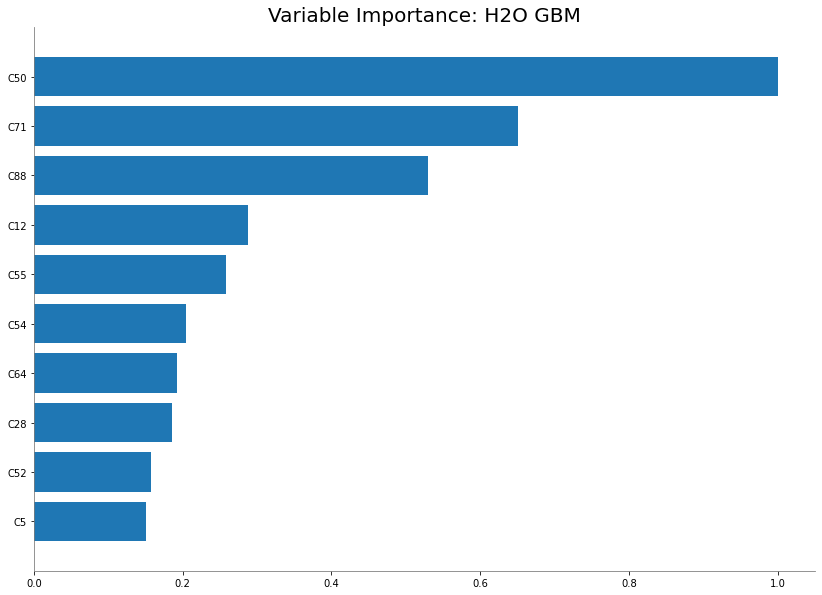

In [46]:
gbm_balanced.varimp_plot()

C50 is important feature for target label.

Headlines column will have text data We will add another feature 'headlines' to our existing trainingset and interpret the performance. 

In [49]:
headline_vecs = vec_model.transform(words_headline, aggregate_method = "AVERAGE")
headline_vecs.names = ["headline_" + s for s in headline_vecs.names]

In [50]:
headline_vecs.head()

headline_C1,headline_C2,headline_C3,headline_C4,headline_C5,headline_C6,headline_C7,headline_C8,headline_C9,headline_C10,headline_C11,headline_C12,headline_C13,headline_C14,headline_C15,headline_C16,headline_C17,headline_C18,headline_C19,headline_C20,headline_C21,headline_C22,headline_C23,headline_C24,headline_C25,headline_C26,headline_C27,headline_C28,headline_C29,headline_C30,headline_C31,headline_C32,headline_C33,headline_C34,headline_C35,headline_C36,headline_C37,headline_C38,headline_C39,headline_C40,headline_C41,headline_C42,headline_C43,headline_C44,headline_C45,headline_C46,headline_C47,headline_C48,headline_C49,headline_C50,headline_C51,headline_C52,headline_C53,headline_C54,headline_C55,headline_C56,headline_C57,headline_C58,headline_C59,headline_C60,headline_C61,headline_C62,headline_C63,headline_C64,headline_C65,headline_C66,headline_C67,headline_C68,headline_C69,headline_C70,headline_C71,headline_C72,headline_C73,headline_C74,headline_C75,headline_C76,headline_C77,headline_C78,headline_C79,headline_C80,headline_C81,headline_C82,headline_C83,headline_C84,headline_C85,headline_C86,headline_C87,headline_C88,headline_C89,headline_C90,headline_C91,headline_C92,headline_C93,headline_C94,headline_C95,headline_C96,headline_C97,headline_C98,headline_C99,headline_C100
0.0185162,-0.115488,0.104139,-0.143702,0.0839418,-0.210495,0.165548,-0.0237721,0.0677472,-0.210758,0.146332,-0.02706,-0.0851666,0.175646,-0.0303567,-0.0231346,0.127572,-0.257409,-0.0396139,-0.202641,0.112528,-0.234912,-0.0518952,0.0509555,0.01597,-0.0443076,-0.0639574,-0.00946881,-0.0257915,0.0813862,-0.130616,0.0773915,-0.187354,0.0549268,0.0793182,0.133722,-0.219832,-0.0862507,0.161767,-0.0155789,-0.0518723,0.0675367,-0.250918,0.054737,-0.123754,-0.052881,-0.0826705,0.0799488,-0.0752862,-0.216457,0.0382488,0.0408937,-0.0222427,-0.104879,0.139049,-0.226703,0.131152,-0.087457,-0.127004,0.0465224,0.11279,-0.101605,0.0482036,0.0300451,0.0378511,0.0933368,0.136996,0.00659768,-0.177429,-0.166329,-0.160486,-0.00917747,-0.259657,-0.0388705,-0.0649821,0.0293493,0.119786,0.0895976,0.0853393,0.177161,0.173283,-0.146074,0.148514,0.116958,-0.124322,0.0521574,-0.16806,0.343714,0.0893526,0.177749,-0.177944,-0.00289423,-0.0617061,0.200867,-0.195197,-0.397215,0.114615,-0.0197639,-0.101276,0.134045
-0.256141,0.128054,0.049158,-0.0522741,-0.129329,-0.276798,0.0497648,0.0845352,0.0658422,0.0267137,0.0488741,-0.0813229,-0.029332,0.128893,-0.100631,-0.147874,-0.102969,0.00460807,-0.00449172,-0.0953896,0.292078,-0.0615605,-0.023682,0.0850246,-0.110983,-0.128311,-0.0457309,0.00132376,-0.163682,0.0272578,-0.0782772,0.0868949,-0.0172827,-0.122709,-0.117107,0.256438,-0.0138599,-0.0286985,-0.110689,0.143452,-0.170705,-0.045254,-0.144815,0.245165,0.00465773,0.0196495,-0.00527802,-0.0856837,-0.0902815,0.0621373,-0.151406,-0.0711627,-0.0477809,-0.0650607,0.0192818,-0.137271,-0.197174,0.00565172,0.0117367,-0.0110454,0.00913789,-0.0531534,0.0428788,-0.0575339,0.0237326,0.0871162,0.0692664,-0.128538,-0.0959218,-0.149638,0.0496946,0.0128069,-0.215921,-0.0111231,-0.194461,-0.050032,0.174148,0.0786157,0.0214978,0.388848,-0.178781,0.208238,0.0825747,0.0376197,-0.0933068,-0.056378,-0.0259837,0.223453,0.150982,0.112689,-0.0494502,-0.0065696,0.102585,-0.128599,-0.107048,-0.143228,0.170052,-0.0355595,-0.0351138,0.116025
0.00677117,-0.253411,0.151693,0.134665,-0.144862,-0.0301804,0.268653,0.0946106,0.15983,-0.117185,-0.0843863,0.0415231,0.0798375,0.0334479,-0.173112,0.0607931,0.0663527,-0.327167,0.0146205,-0.270798,0.179474,-0.0317777,-0.247896,-0.0369141,0.0873388,0.0256046,0.117235,-0.00999106,-0.0946028,-0.0251317,0.038455,0.0846743,-0.20361,-0.0450722,-0.0161956,0.213831,-0.0283599,-0.16818,-0.137063,0.0389218,-0.166388,-0.0718722,0.0896883,0.325054,-0.340046,-0.210007,-0.0169523,-0.0686789,0.0114041,-0.208002,0.187957,-0.0166331,-0.132881,-0.128075,-0.0443474,-0.305538,-0.190487,-0.154193,0.0518813,-0.208101,0.152121,-0.226284,-0.00527288,-0.183437,0.223585,0.144358,-0.0625074,0.0391924,0.047763

In [51]:
h2o_df_ext = h2o_df_ext.cbind(headline_vecs)

In [52]:
h2o_train,h2o_valid = h2o_df_ext.split_frame(ratios=[.8])
gbm_two_cols = H2OGradientBoostingEstimator(stopping_metric = "AUC", stopping_tolerance = 0.001,
                                              stopping_rounds = 5, score_tree_interval = 10
                                             )

In [53]:
gbm_two_cols.train(x=headline_vecs.names+review_vecs.names, y='target', training_frame = h2o_train, validation_frame=h2o_valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [55]:
print(" Two Columns AUC: " + str(round(gbm_two_cols.auc(valid = True), 3)))

 Two Columns AUC: 0.919


In [56]:
gbm_two_cols.confusion_matrix(valid=True)


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5403767312006856: 


,,0,1,Error,Rate
0,0,3092.0,1654.0,0.3485,(1654.0/4746.0)
1,1,675.0,11838.0,0.0539,(675.0/12513.0)
2,Total,3767.0,13492.0,0.1349,(2329.0/17259.0)


In [57]:
gbm_two_cols.score_history()

,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-09-01 11:48:25,0.012 sec,0.0,0.444905,0.585075,0.500000,0.728166,1.000000,0.271834,0.446519,0.588181,0.500000,0.725013,1.000000,0.274987
1,,2020-09-01 11:48:35,10.027 sec,10.0,0.367218,0.432364,0.893406,0.954506,1.371284,0.157562,0.372169,0.440855,0.882401,0.948953,1.379286,0.166927
2,,2020-09-01 11:48:43,18.116 sec,20.0,0.336962,0.373389,0.911361,0.962595,1.369972,0.143273,0.344579,0.385881,0.898932,0.956727,1.379286,0.152732
3,,2020-09-01 11:48:51,25.964 sec,30.0,0.319923,0.339626,0.922404,0.967419,1.371318,0.133101,0.330221,0.356066,0.908609,0.961094,1.379286,0.144794
4,,2020-09-01 11:48:58,33.896 sec,40.0,0.308862,0.317598,0.929944,0.970789,1.373314,0.126379,0.321622,0.337831,0.914636,0.963829,1.379286,0.138305
5,,2020-09-01 11:49:06,41.704 sec,50.0,0.300598,0.301505,0.935907,0.973458,1.373314,0.120325,0.315632,0.325165,0.919159,0.965851,1.379286,0.134944


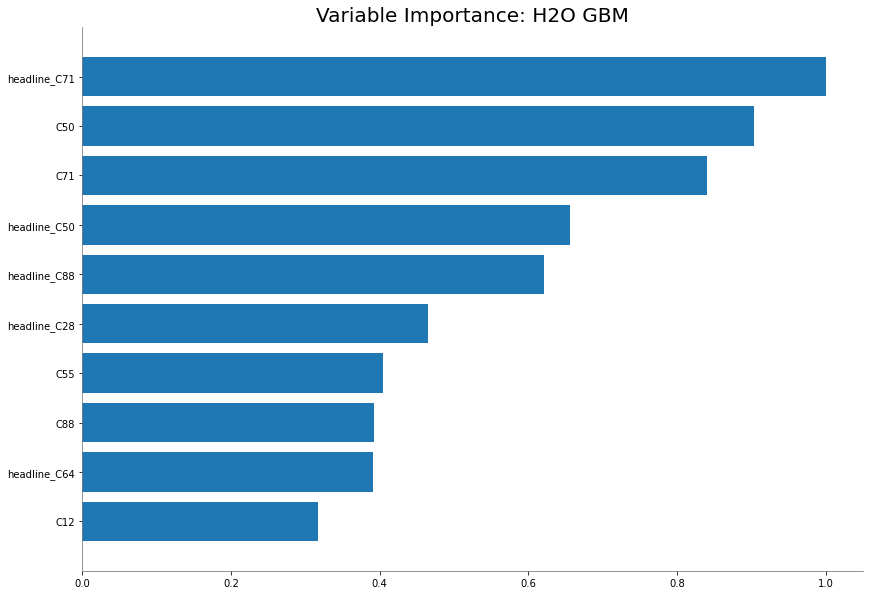

In [58]:
gbm_two_cols.varimp_plot()

In [41]:
ntrees_opt = [100, 200, 250, 300]
max_depth_opt = [6, 7, 8]
learn_rate_opt = [0.01, 0.1]

hyper_parameters = {"ntrees": ntrees_opt,"max_depth":max_depth_opt, "learn_rate":learn_rate_opt}
search_criteria = {"strategy":"RandomDiscrete","max_models":4}

In [59]:
from h2o.grid.grid_search import H2OGridSearch
gs = H2OGridSearch(H2OGradientBoostingEstimator,hyper_params=hyper_parameters, search_criteria=search_criteria)

In [60]:
gs.train(x=review_vecs.names+headline_vecs.names, y='target', training_frame = h2o_train, validation_frame=h2o_valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [61]:
print(gs.get_grid(sort_by='auc', decreasing=True))

     ...                 auc
0    ...  0.9388272269321996
1    ...  0.9386107474774906
2    ...   0.924302054982077
3    ...  0.8944977880400085

[4 rows x 6 columns]



Maximum AUC score using our hyperparameter range resulted in 94%.

In [67]:
# Grab the top GBM model, chosen by validation AUC
best_gbm = gs.models[0]
print(best_gbm)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_py_389_sid_b439_model_python_1598957704201_325_model_2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,200.0,200.0,159059.0,6.0,6.0,6.0,45.0,64.0,58.635




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.045413736895079354
RMSE: 0.21310499031012708
LogLoss: 0.16701256895298922
Mean Per-Class Error: 0.06107120152481871
AUC: 0.9845441426751224
AUCPR: 0.9938369694895844
Gini: 0.9690882853502447

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5901255526178099: 


,,0,1,Error,Rate
0,0,16781.0,1900.0,0.1017,(1900.0/18681.0)
1,1,1694.0,48347.0,0.0339,(1694.0/50041.0)
2,Total,18475.0,50247.0,0.0523,(3594.0/68722.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.590126,0.964163,202.0
1,max f2,0.385543,0.975332,260.0
2,max f0point5,0.704810,0.968795,165.0
3,max accuracy,0.593359,0.947717,201.0
4,max precision,0.998046,1.000000,0.0
5,max recall,0.019593,1.000000,388.0
6,max specificity,0.998046,1.000000,0.0
7,max absolute_mcc,0.593359,0.867610,201.0
8,max min_per_class_accuracy,0.690005,0.938708,170.0
9,max mean_per_class_accuracy,0.684434,0.938929,172.0



Gains/Lift Table: Avg response rate: 72.82 %, avg score: 72.81 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010186,0.998127,1.373314,1.373314,1.000000,0.998345,1.000000,0.998345,0.013989,0.013989,37.331388,37.331388,0.013989
1,2,0.020095,0.997809,1.373314,1.373314,1.000000,0.997946,1.000000,0.998148,0.013609,0.027597,37.331388,37.331388,0.027597
2,3,0.032115,0.997441,1.373314,1.373314,1.000000,0.997598,1.000000,0.997942,0.016506,0.044104,37.331388,37.331388,0.044104
3,4,0.040220,0.997106,1.373314,1.373314,1.000000,0.997258,1.000000,0.997804,0.011131,0.055235,37.331388,37.331388,0.055235
4,5,0.050013,0.996686,1.373314,1.373314,1.000000,0.996899,1.000000,0.997627,0.013449,0.068684,37.331388,37.331388,0.068684
5,6,0.100012,0.994313,1.372914,1.373114,0.999709,0.995562,0.999855,0.996595,0.068644,0.137327,37.291420,37.311407,0.137274
6,7,0.150010,0.991105,1.372914,1.373047,0.999709,0.992766,0.999806,0.995319,0.068644,0.205971,37.291420,37.304745,0.205864
7,8,0.200009,0.986977,1.372115,1.372814,0.999127,0.989126,0.999636,0.993771,0.068604,0.274575,37.211483,37.281431,0.274307
8,9,0.300006,0.975500,1.371915,1.372515,0.998981,0.981671,0.999418,0.989738,0.137188,0.411762,37.191499,37.251455,0.411120
9,10,0.400003,0.956282,1.365320,1.370716,0.994179,0.966769,0.998108,0.983996,0.136528,0.548290,36.532020,37.071603,0.545507




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.08352402480366504
RMSE: 0.2890052331769531
LogLoss: 0.2714556504026696
Mean Per-Class Error: 0.14079281693688372
AUC: 0.9388272269321996
AUCPR: 0.9742607971865564
Gini: 0.8776544538643991

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48550214455117363: 


,,0,1,Error,Rate
0,0,3325.0,1421.0,0.2994,(1421.0/4746.0)
1,1,589.0,11924.0,0.0471,(589.0/12513.0)
2,Total,3914.0,13345.0,0.1165,(2010.0/17259.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.485502,0.922268,236.0
1,max f2,0.237258,0.956901,309.0
2,max f0point5,0.749172,0.923737,146.0
3,max accuracy,0.560868,0.884350,213.0
4,max precision,0.998160,1.000000,0.0
5,max recall,0.008742,1.000000,394.0
6,max specificity,0.998160,1.000000,0.0
7,max absolute_mcc,0.594501,0.704950,203.0
8,max min_per_class_accuracy,0.754597,0.858196,144.0
9,max mean_per_class_accuracy,0.749172,0.859207,146.0



Gains/Lift Table: Avg response rate: 72.50 %, avg score: 73.27 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010082,0.998042,1.379286,1.379286,1.000000,0.998316,1.000000,0.998316,0.013906,0.013906,37.928554,37.928554,0.013906
1,2,0.020511,0.997752,1.379286,1.379286,1.000000,0.997894,1.000000,0.998102,0.014385,0.028291,37.928554,37.928554,0.028291
2,3,0.030419,0.997441,1.379286,1.379286,1.000000,0.997568,1.000000,0.997928,0.013666,0.041956,37.928554,37.928554,0.041956
3,4,0.040037,0.997091,1.379286,1.379286,1.000000,0.997249,1.000000,0.997765,0.013266,0.055223,37.928554,37.928554,0.055223
4,5,0.050408,0.996626,1.379286,1.379286,1.000000,0.996849,1.000000,0.997576,0.014305,0.069528,37.928554,37.928554,0.069528
5,6,0.100006,0.993979,1.376063,1.377687,0.997664,0.995387,0.998841,0.996491,0.068249,0.137777,37.606291,37.768730,0.137355
6,7,0.150009,0.990799,1.376089,1.377155,0.997683,0.992507,0.998455,0.995163,0.068808,0.206585,37.608905,37.715455,0.205742
7,8,0.200012,0.986523,1.368098,1.374890,0.991889,0.988760,0.996813,0.993562,0.068409,0.274994,36.809783,37.489037,0.272676
8,9,0.300017,0.973337,1.362504,1.370762,0.987833,0.980537,0.993820,0.989220,0.136258,0.411252,36.250397,37.076157,0.404510
9,10,0.400023,0.951270,1.328142,1.360107,0.962920,0.963469,0.986095,0.982782,0.132822,0.544074,32.814170,36.010660,0.523847




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-09-01 11:55:40,1 min 35.072 sec,0.0,0.444905,0.585075,0.500000,0.728166,1.000000,0.271834,0.446519,0.588181,0.500000,0.725013,1.000000,0.274987
1,,2020-09-01 11:55:41,1 min 36.222 sec,1.0,0.430678,0.554668,0.831678,0.921404,1.353337,0.188208,0.432779,0.558690,0.822749,0.915541,1.358801,0.195260
2,,2020-09-01 11:55:42,1 min 37.129 sec,2.0,0.418469,0.530173,0.859607,0.937366,1.364183,0.176421,0.420995,0.534883,0.852156,0.933613,1.370649,0.183093
3,,2020-09-01 11:55:43,1 min 38.113 sec,3.0,0.407832,0.509463,0.871962,0.944254,1.369775,0.171852,0.410785,0.514840,0.863741,0.940313,1.377265,0.177820
4,,2020-09-01 11:55:48,1 min 42.713 sec,8.0,0.369094,0.436678,0.900474,0.957661,1.372521,0.150141,0.374520,0.445843,0.888882,0.952228,1.379286,0.163103
5,,2020-09-01 11:55:52,1 min 47.132 sec,13.0,0.346110,0.393175,0.910912,0.962230,1.372047,0.141832,0.354392,0.406721,0.896054,0.955285,1.379286,0.158352
6,,2020-09-01 11:55:57,1 min 51.582 sec,18.0,0.330018,0.362168,0.920457,0.966405,1.372015,0.134324,0.340605,0.379065,0.903984,0.958837,1.379286,0.150820
7,,2020-09-01 11:56:01,1 min 55.942 sec,23.0,0.319006,0.340510,0.927538,0.969613,1.371380,0.128983,0.331637,0.360453,0.909727,0.961470,1.379286,0.144388
8,,2020-09-01 11:56:06,2 min 0.322 sec,28.0,0.310349,0.323623,0.932881,0.971992,1.371338,0.122872,0.325179,0.346894,0.913712,0.963199,1.379286,0.142245
9,,2020-09-01 11:56:10,2 min 4.662 sec,33.0,0.303160,0.309705,0.937198,0.973855,1.373314,0.118739,0.320229,0.336218,0.916709,0.964559,1.379286,0.137493



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,headline_C71,3412.558105,1.000000,0.068320
1,C50,3262.759766,0.956104,0.065321
2,C71,2651.550293,0.776998,0.053085
3,headline_C88,2089.722412,0.612362,0.041837
4,headline_C50,1949.924072,0.571397,0.039038
5,C55,1447.333618,0.424120,0.028976
6,headline_C28,1443.504150,0.422998,0.028899
7,headline_C64,1441.554321,0.422426,0.028860
8,C88,1401.110840,0.410575,0.028051
9,C12,1130.285767,0.331214,0.022629



See the whole table with table.as_data_frame()

